In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import sklearn
from tqdm import tqdm

In [3]:
train_features = pd.read_csv("train_features.csv").sort_values(by='pid')
test = pd.read_csv("test_features.csv")
train_labels = pd.read_csv("train_labels.csv").sort_values(by='pid')



In [4]:
# Let's get rid of Hgb, HCO3, ABPd, and Bilirubin_direct from the training and test data !

# train_features.drop('Bilirubin_direct', axis=1, inplace=True)
# train_features.drop('HCO3', axis=1, inplace=True)
# train_features.drop('Hgb', axis=1, inplace=True)
# train_features.drop('ABPd', axis=1, inplace=True)

# test.drop('Bilirubin_direct', axis=1, inplace=True)
# test.drop('HCO3', axis=1, inplace=True)
# test.drop('Hgb', axis=1, inplace=True)
# test.drop('ABPd', axis=1, inplace=True) 

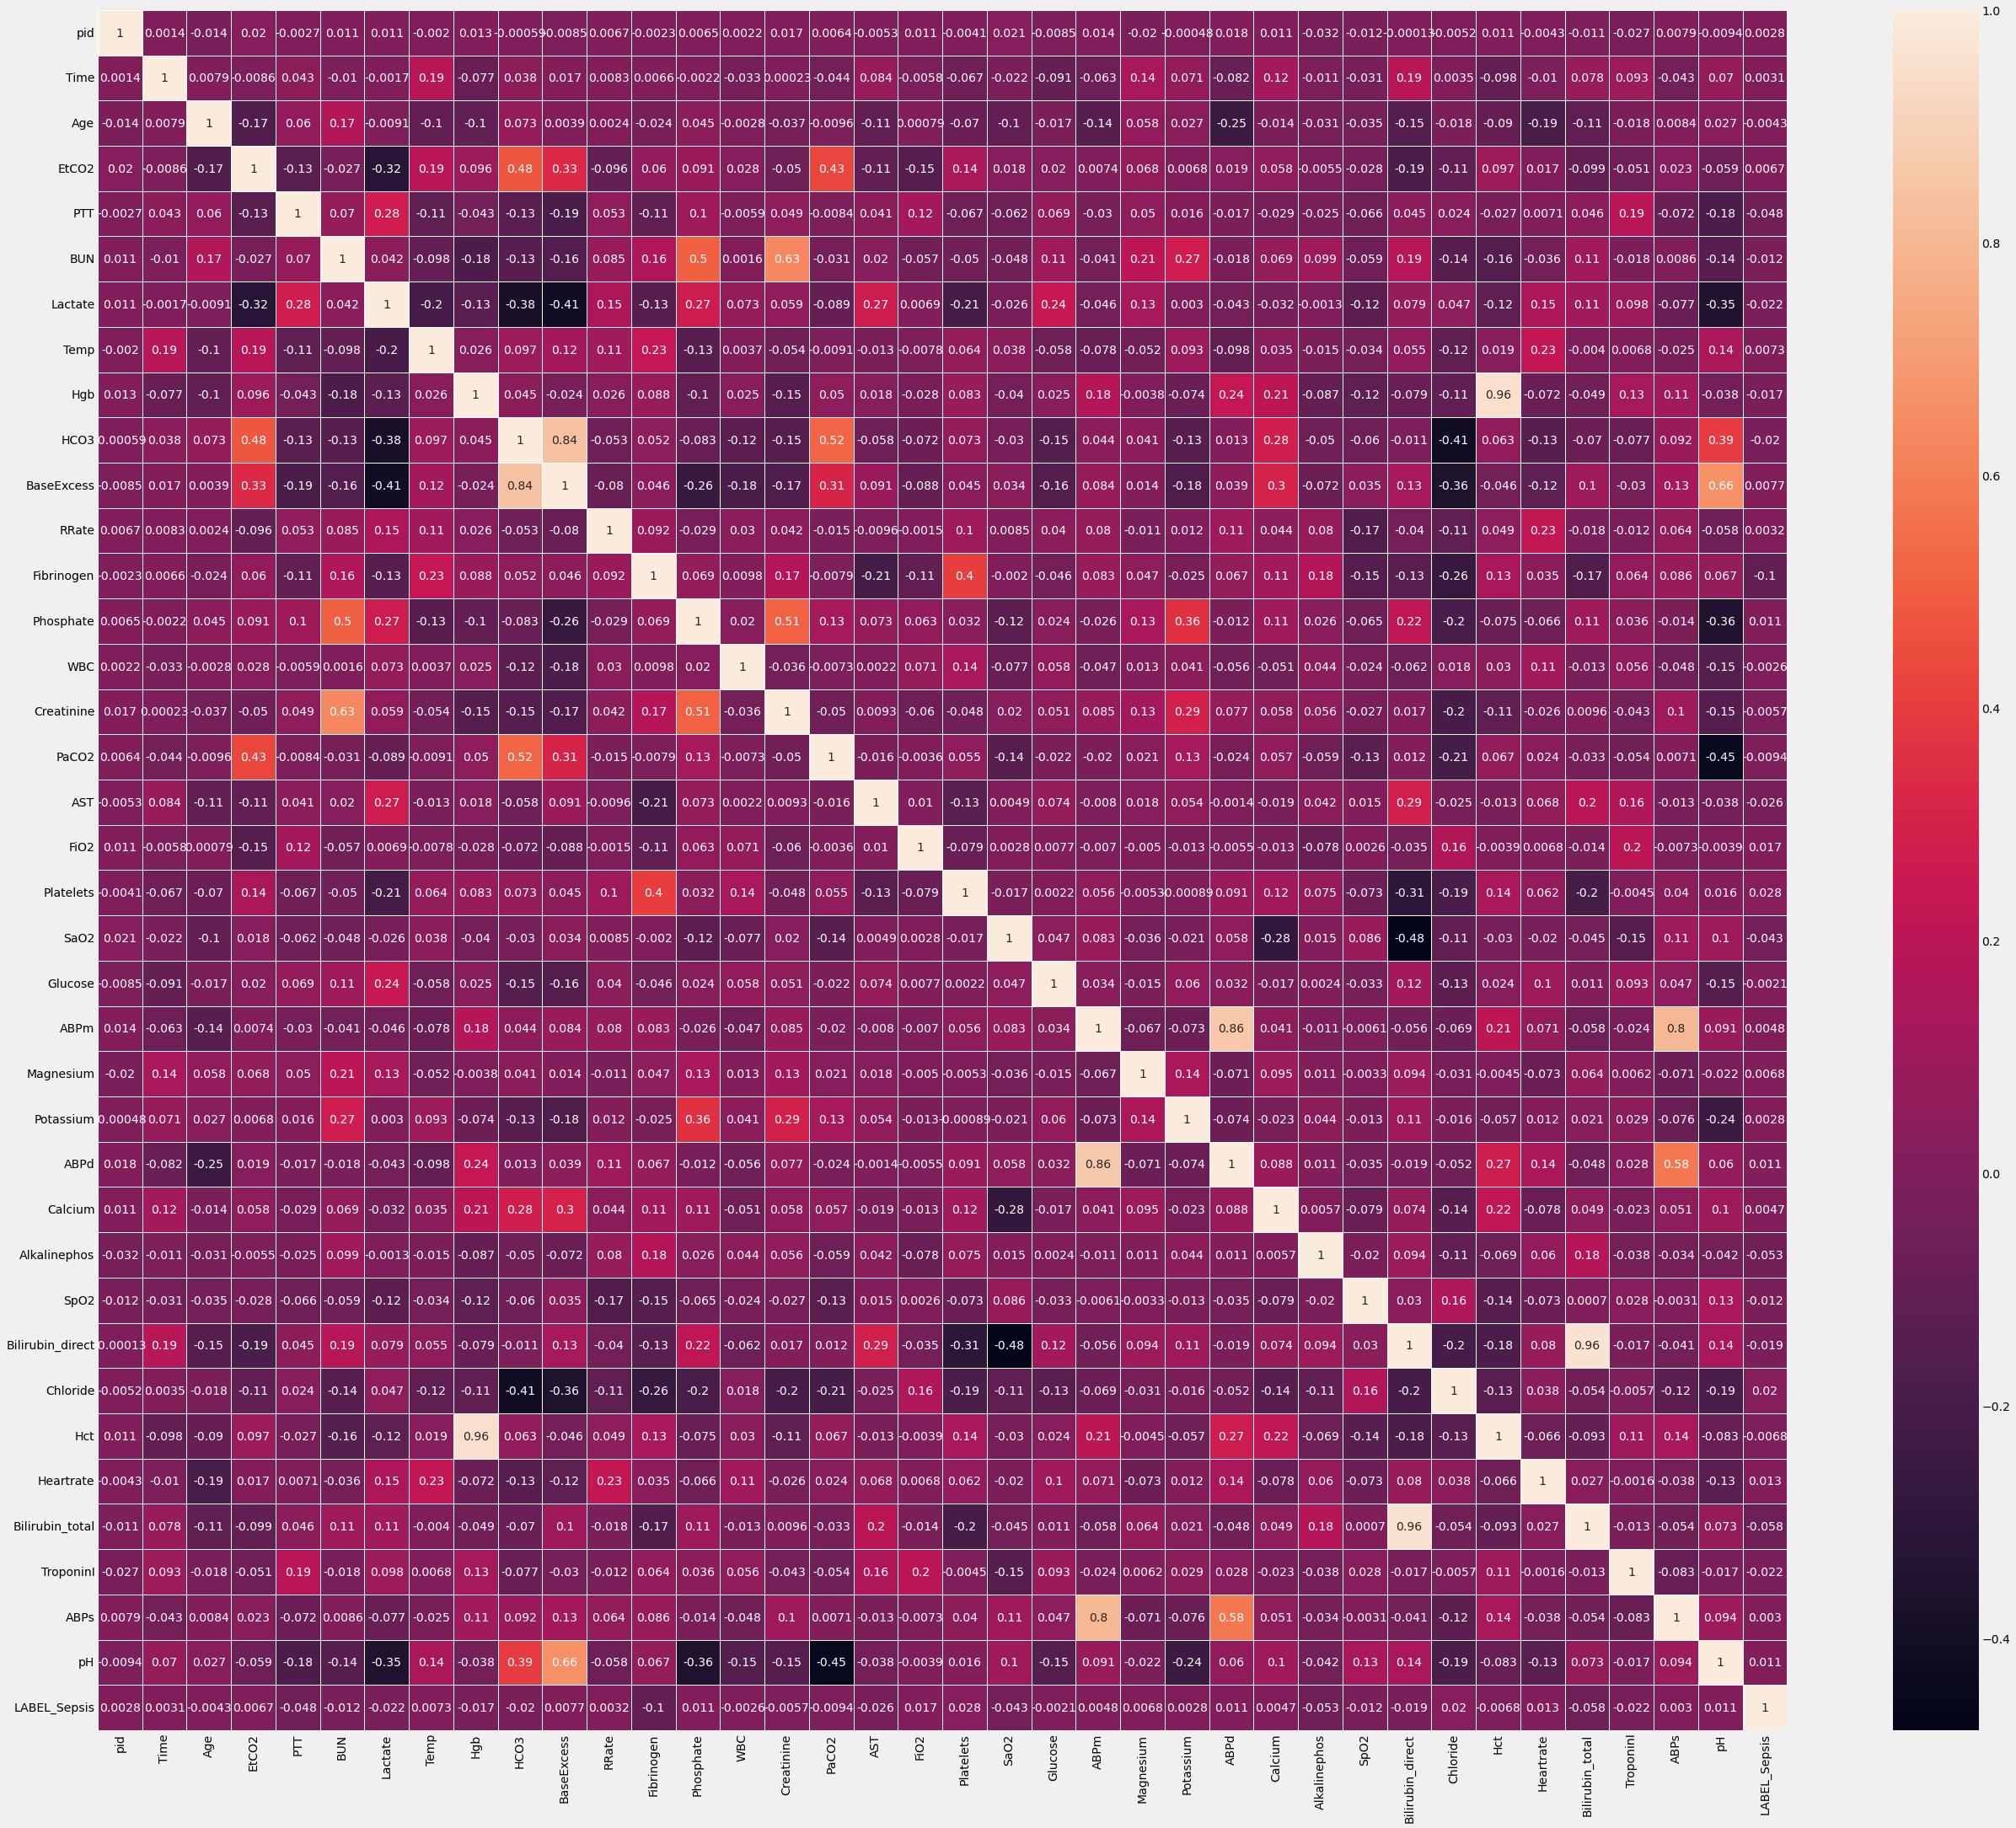

In [5]:
# Let's now look at the correlation heatmap of the train data 

import matplotlib.pyplot as plt
import seaborn as sns

def corr_check(data):
    
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(40,35))         # Sample figsize in inches
    sns.heatmap(data.corr(), linewidths=.5, ax=ax, annot= True)
    plt.show()
    
raw_data = pd.concat([train_features, train_labels['LABEL_Sepsis']], axis=1, sort=False)
corr_check(raw_data)

In [6]:
def impute_KNN(df):
    imputed_df = pd.DataFrame(columns=df.columns)
    imp = sklearn.impute.KNNImputer(n_neighbors=1)
    for pid in tqdm(np.unique(df['pid'].values)):
        temp_df = df.loc[df['pid'] == pid]
        temp_df2 = temp_df.dropna(axis = 'columns', how = 'all')
        imp.fit(temp_df2)
        temp_df2 = pd.DataFrame(data = imp.transform(temp_df2), columns = temp_df2.columns)
        for key in temp_df.columns:
            if temp_df[key].isna().all():
                temp_df2[key] = np.nan
        imputed_df = imputed_df.append(temp_df2, sort = True)
    imputed_df.reindex(columns = df.columns)
    return imputed_df

In [7]:
print("Imputing training data")

train_features_imp = impute_KNN(train_features)

print ("###############################")

print("Imputing test data")


test_imputed = impute_KNN(test)

Imputing training data


100%|██████████| 18995/18995 [10:00<00:00, 31.65it/s]


###############################
Imputing test data


100%|██████████| 12664/12664 [07:02<00:00, 30.01it/s]


In [8]:
def impute_mode(df):
    for column in df.columns:
        df[column].fillna(df[column].mode()[0], inplace=True)
    return df

In [9]:
train_features_imp = impute_mode(train_features_imp)
test = impute_mode(test_imputed)

In [10]:
# Here, we would like to have one patient per row. Each feature has a time-series observations and we will extract standard set of features.
from scipy.stats import kurtosis, skew


def feature_extract(column, df):
    
    minimum = df[column].min()
    maximum = df[column].max()
    mean = np.float32(df[column].mean())
    standard_deviation = np.float32(df[column].std())
    median = np.float(df[column].median())
    skewness = np.float(df[column].skew())
    kurtosis = np.float(df[column].kurtosis())
    
    return minimum, maximum, mean, standard_deviation, median, skewness, kurtosis

# Let's create a dictionary to store new features

def new_df(df):

    new_df = {}

    for column in df.columns[(df.columns!='pid') & (df.columns!='Age') & (df.columns!='Time')]:  # We don't really need pid, Age and Time 
        new_df[column+'_minimum'] = []
        new_df[column+'_maximum'] = []
        new_df[column+'_mean'] = []
        new_df[column+'_std'] = [] 
        new_df[column+'_median'] = []
        new_df[column+'_skewness'] = []
        new_df[column+'_kurtosis'] = []

    new_df['pid'] = []
    new_df['Age'] = []

    # Create a new dataframe with new extracted features

    for pid in tqdm(df.pid.unique()):

        for column in df.columns[(df.columns!='pid') & (df.columns!='Age') & (df.columns!='Time')]:
            #print(column)
            minimum, maximum, mean, standard_deviation, median, skewness, kurtosis = feature_extract(column, df[df.pid == pid])    
            #print(minimum, maximum, mean, standard_deviation)
            new_df[column+'_minimum'].append(minimum)
            new_df[column+'_maximum'].append(maximum)
            new_df[column+'_mean'].append(mean)
            new_df[column+'_std'].append(standard_deviation)
            new_df[column+'_median'].append(median)
            new_df[column+'_skewness'].append(skewness)
            new_df[column+'_kurtosis'].append(kurtosis)

            
        new_df['pid'].append(pid)
        age = np.array(df.loc[df['pid'] == pid].Age)
        #print (age[0])
        new_df['Age'].append(age[0])
        
    new_df = pd.DataFrame.from_dict(new_df)
    return new_df

print ("Extracting new features from the training data")

new_train_features_imp = new_df(train_features_imp)

print ("###############################")

print ("Extracting new features from the test data")
new_test_features_imp = new_df(test)

Extracting new features from the training data


100%|██████████| 18995/18995 [09:23<00:00, 33.71it/s]


###############################
Extracting new features from the test data


100%|██████████| 12664/12664 [06:18<00:00, 33.42it/s]


In [11]:
feature_cols = new_train_features_imp.columns.values[(new_train_features_imp.columns.values != 'pid') & (new_train_features_imp.columns.values != 'Time')]

X_train= new_train_features_imp[feature_cols]
X_test = new_test_features_imp[feature_cols]

In [12]:
# Task 1 and Task 2 
from sklearn.ensemble import RandomForestClassifier


TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
          'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
          'LABEL_Bilirubin_direct', 'LABEL_EtCO2','LABEL_Sepsis']


df_submission = pd.DataFrame(new_test_features_imp.pid.values, columns = ['pid'])


for label in tqdm(TESTS):
    
  
    if label == 'LABEL_AST' or label == 'LABEL_Lactate' or label == 'LABEL_Bilirubin_total' or label == 'LABEL_Bilirubin_direct' or label == 'LABEL_TroponinI' or label == 'LABEL_Sepsis':
        
        y_train_temp = train_labels[label]
        model = RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 200, random_state=42)
        model.fit(X_train, y_train_temp)
        predictions_prob_test = model.predict_proba(X_test)
        predict_prob_test = pd.DataFrame(np.ravel(predictions_prob_test[:,1]), columns = [label])
        df_submission = pd.concat([df_submission, predict_prob_test], axis = 1, sort = False)
         
    else:
        
        y_train_temp = train_labels[label]
        model = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, random_state=42)
        model.fit(X_train, y_train_temp)
        predictions_prob_test = model.predict_proba(X_test)
        predict_prob_test = pd.DataFrame(np.ravel(predictions_prob_test[:,1]), columns = [label])
        df_submission = pd.concat([df_submission, predict_prob_test], axis = 1, sort = False)


100%|██████████| 11/11 [03:54<00:00, 21.32s/it]


In [ ]:
# Task 3

VITALS = ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


feature_cols = X_train.columns.values[(X_train.columns.values != 'pid') & (X_train.columns.values != 'Time')]

X_train = X_train[feature_cols]
X_test = X_test[feature_cols]

for label in VITALS:

    if label == 'LABEL_SpO2':

        y_temp = train_labels[label]
        reg = LinearRegression().fit(X_train, y_temp) # fitting the data
        y_pred = pd.DataFrame(reg.predict(X_test), columns = [label])
        df_submission = pd.concat([df_submission, y_pred], axis = 1, sort = False)
    
    else:
        y_temp = train_labels[label]
        rfr = RandomForestRegressor(random_state = 2020, n_estimators = 200).fit(X_train, y_temp) # fitting the data
        y_pred = pd.DataFrame(rfr.predict(X_test), columns = [label])
        df_submission = pd.concat([df_submission, y_pred], axis = 1, sort = False)

In [ ]:
df_submission.to_csv(r'predictions.csv', index = False, float_format='%.3f')
print ("All done !")